In [48]:
#!/usr/bin/env python
# coding: utf-8

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import json
import time

import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks



In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
# Load configuration from JSON file
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print("✓ Configuration loaded successfully!")
except FileNotFoundError:
    print("✗ Error: config.json file not found!")
    raise
except json.JSONDecodeError as e:
    print(f"✗ Error: Invalid JSON in config.json: {e}")
    raise
except Exception as e:
    print(f"✗ Unexpected error loading config: {e}")
    raise

✓ Configuration loaded successfully!


In [51]:
# CUDA initialization and reproducible randomization
seed = 0

np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.synchronize()

print(f"CUDA available: {torch.cuda.is_available()}, seed set to {seed}")

CUDA available: False, seed set to 0


In [52]:
import os

# Loader the picker
try:
    model = sbm.PhaseNet.from_pretrained("stead")
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    raise

✓ Model loaded successfully!


In [53]:
# Set up device
device = torch.device(f"cuda:{config['device']['device_id']}" if torch.cuda.is_available() and config['device']['use_cuda'] else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [8]:
# Print PhaseNet model information
phasenet_total_params = sum(p.numel() for p in model.parameters())
phasenet_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("PhaseNet information:")
print(f"Total parameters: {phasenet_total_params:,}")
print(f"Trainable parameters: {phasenet_trainable_params:,}")
print(f"Model size: {phasenet_total_params * 4 / (1024**2):.2f} MB (float32)")

PhaseNet information:
Total parameters: 268,443
Trainable parameters: 268,443
Model size: 1.02 MB (float32)


In [54]:
import sys
sys.path.insert(0, '../')

from models.xn_xiao_net_v5 import XiaoNetEdge

# Load XiaoNetEdge with base_channels=8
xiaonet_edge = XiaoNetEdge(window_len=3001, in_channels=3, num_phases=3, base_channels=8)
xiaonet_edge.to(device)

# Count parameters
xiaonet_edge_total_params = sum(p.numel() for p in xiaonet_edge.parameters())
xiaonet_edge_trainable_params = sum(p.numel() for p in xiaonet_edge.parameters() if p.requires_grad)

print(f"XiaoNetEdge Model Architecture:")
print(xiaonet_edge)
print(f"\nTotal Parameters: {xiaonet_edge_total_params:,}")
print(f"Trainable Parameters: {xiaonet_edge_trainable_params:,}")
print(f"\nParameter Reduction vs PhaseNet: {(1 - xiaonet_edge_total_params/phasenet_total_params)*100:.1f}%")

XiaoNetEdge Model Architecture:
XiaoNetEdge(
  (skip_add3): FloatFunctional(
    (activation_post_process): Identity()
  )
  (skip_add2): FloatFunctional(
    (activation_post_process): Identity()
  )
  (skip_add1): FloatFunctional(
    (activation_post_process): Identity()
  )
  (enc1): Sequential(
    (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,), padding=(1,), groups=3, bias=False)
    (1): Conv1d(3, 8, kernel_size=(1,), stride=(1,), bias=False)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Hardswish()
  )
  (enc2): Sequential(
    (0): Conv1d(8, 8, kernel_size=(3,), stride=(4,), padding=(1,), groups=8, bias=False)
    (1): Conv1d(8, 16, kernel_size=(1,), stride=(1,), bias=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Hardswish()
  )
  (enc3): Sequential(
    (0): Conv1d(16, 16, kernel_size=(3,), stride=(4,), padding=(1,), groups=16, bias=False)
    (1): Conv1d(16, 32, ker

In [55]:
# Load the data
print("Loading data...")
try:
    data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")
    print("✓ Data loaded successfully!")

except Exception as e:
    print(f"✗ Error loading data: {e}")
    raise

Loading data...
✓ Data loaded successfully!


In [13]:
# Create a random sample
sample_fraction = 0.01  # Sample 20% of the data
print(f"Creating random sample of {sample_fraction*100}% of the data...")

Creating random sample of 1.0% of the data...


In [56]:
# Create a random mask for sampling
mask = np.random.random(len(data)) < sample_fraction
data.filter(mask)

print(f"Sampled dataset size: {len(data)}")

Sampled dataset size: 11270


In [57]:
# magnitude filtering (with defaults)
min_magnitude = config.get('data_filter', {}).get('min_magnitude', -1.0)
max_magnitude = config.get('data_filter', {}).get('max_magnitude', 10.0)

try:
    # Filter events with magnitude above the minimum
    print(f"✓ [Data Filter]: Start - magnitude > {min_magnitude}")
    mask = data.metadata["source_magnitude"] > min_magnitude
    data.filter(mask)
    print(f"✓ [Data Filter]: Applied - magnitude > {min_magnitude}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply minimum magnitude filter.")
    print(f"  Details: {exc}")
    raise

try:
    # Filter events with magnitude below the maximum
    print(f"✓ [Data Filter]: Start - magnitude < {max_magnitude}")
    mask = data.metadata["source_magnitude"] < max_magnitude
    data.filter(mask)
    print(f"✓ [Data Filter]: Applied - magnitude < {max_magnitude}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply maximum magnitude filter.")
    print(f"  Details: {exc}")
    raise

✓ [Data Filter]: Start - magnitude > 1.0
✓ [Data Filter]: Applied - magnitude > 1.0
✓ [Data Filter]: Start - magnitude < 2.0
✓ [Data Filter]: Applied - magnitude < 2.0


In [58]:

print(f"Sampled dataset size: {len(data)}")


Sampled dataset size: 3723


In [59]:
print("Sample metadata:")
data.metadata.head(20)

Sample metadata:


,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
524,524,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-15T18:13:14.055000Z,earthquake_local,"bucket0$377,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-15T1813142024-03-1...,,100,ZNE
540,540,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-22T08:27:12.879999Z,earthquake_local,"bucket0$391,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-22T0827122024-03-2...,,100,ZNE
742,742,2V,TG11,EHE,35.26890,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2024-07-12T12:18:13.550000Z,earthquake_local,"bucket4$82,:3,:12001",dev,2V.TG11.EHE.EHN.EHZ.2024-07-12T1218132024-07-1...,,100,ZNE
757,757,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-07-18T08:17:44.720000Z,earthquake_local,"bucket0$549,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-07-18T0817442024-07-1...,,100,ZNE
1062,1062,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-11-19T21:40:44.520000Z,earthquake_local,"bucket5$173,:3,:12001",test,2V.TG11.EHE.EHN.EHZ.2024-11-19T2140442024-11-1...,,100,ZNE
1070,1070,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-12-07T04:18:22.749999Z,earthquake_local,"bucket0$759,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-12-07T0418222024-12-0...,,100,ZNE
1130,1130,2V,TG11,EHE,35.26890,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-19T22:35:23.879999Z,earthquake_local,"bucket0$798,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-19T2235232025-02-1...,,100,ZNE
1747,1747,AG,HHAR,HHE,36.28200,-93.9400,421.0,5999.0,manual,1.0,...,NaN,NaN,2014-12-02T01:51:29.870000Z,earthquake_local,"bucket5$289,:3,:12001",test,AG.HHAR.HHE.HHN.HHZ.2014-12-02T0151292014-12-0...,,100,ZNE
1947,1947,AG,HHAR,HHE,36.28200,-93.9400,421.0,5999.0,manual,1.0,...,NaN,NaN,2015-03-07T22:26:49.220000Z,earthquake_local,"bucket4$282,:3,:12001",dev,AG.HHAR.HHE.HHN.HHZ.2015-03-07T2226492015-03-0...,,100,ZNE
4310,4310,AG,HHAR,HHE,36.28200,-93.9400,421.0,5999.0,manual,1.0,...,NaN,NaN,2020-06-24T16:06:15.695000Z,earthquake_local,"bucket2$963,:3,:12001",train,AG.HHAR.HHE.HHN.HHZ.2020-06-24T1606152020-06-2...,,100,ZNE


In [60]:
# Split data
train, dev, test = data.train_dev_test()

In [61]:

print("Train:", train)
print("Dev:", dev)
print("Test:", test)


Train: OKLA_1Mil_120s_Ver_3 - 2629 traces
Dev: OKLA_1Mil_120s_Ver_3 - 531 traces
Test: OKLA_1Mil_120s_Ver_3 - 563 traces


In [62]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [63]:
# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

In [64]:
# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)


In [65]:
# Parameters for peak detection (with defaults)
sampling_rate = config.get('peak_detection', {}).get('sampling_rate', 100)
height = config.get('peak_detection', {}).get('height', 0.5)
distance = config.get('peak_detection', {}).get('distance', 100)

print(f"✓ [Peak Detection]: sampling_rate={sampling_rate} Hz, height={height}, distance={distance}")


✓ [Peak Detection]: sampling_rate=100 Hz, height=0.5, distance=100


In [66]:
# Parameters for peak detection
batch_size = config['training']['batch_size']
num_workers = config['training']['num_workers']
print(f"✓ [DataLoader]: batch_size={batch_size}, num_workers={num_workers}")

✓ [DataLoader]: batch_size=64, num_workers=4


In [67]:
print("=" * 60)
print("TRAINING CONFIGURATION SANITY CHECK")
print("=" * 60)

print("\n- Dataset Information:")
print(f"  Total dataset size: {len(data):,} samples")
print(f"  Training set: {len(train):,} samples")
print(f"  Validation set: {len(dev):,} samples")
print(f"  Test set: {len(test):,} samples")
print(f"  Sample fraction used: {sample_fraction*100}%")

print(f"  Device: {device}")

print("\n- Training Hyperparameters:")
print(f"  Batch size: {batch_size}")
print(f"  Number of workers: {num_workers}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Number of epochs: {config['training']['epochs']}")
print(f"  Patience (early stopping): {config['training']['patience']}")

print("\n- Peak Detection Parameters:")
print(f"  Sampling rate: {sampling_rate} Hz")
print(f"  Height threshold: {height}")
print(f"  Distance: {distance} samples")

print("\n" + "=" * 60)
print("Ready to start training!")
print("=" * 60)

TRAINING CONFIGURATION SANITY CHECK

- Dataset Information:
  Total dataset size: 3,723 samples
  Training set: 2,629 samples
  Validation set: 531 samples
  Test set: 563 samples
  Sample fraction used: 1.0%
  Device: cpu

- Training Hyperparameters:
  Batch size: 64
  Number of workers: 4
  Learning rate: 0.01
  Number of epochs: 50
  Patience (early stopping): 5

- Peak Detection Parameters:
  Sampling rate: 100 Hz
  Height threshold: 0.5
  Distance: 100 samples

Ready to start training!


In [68]:
print("=" * 80)
print("TEACHER MODEL (PhaseNet)")
print("=" * 80)
#print(model)
print(f"\nTeacher Total Parameters: {phasenet_total_params:,}")
print(f"Teacher Trainable Parameters: {phasenet_trainable_params:,}")

print("\n" + "=" * 80)
print("STUDENT MODEL (XiaoNetEdge, base_channels=8)")
print("=" * 80)
#print(xiaonet_edge)
print(f"\nStudent Total Parameters: {xiaonet_edge_total_params:,}")
print(f"Student Trainable Parameters: {xiaonet_edge_trainable_params:,}")

print("\n" + "=" * 80)
print("COMPARISON")
print("=" * 80)
print(f"Parameter Reduction: {(1 - xiaonet_edge_total_params/phasenet_total_params)*100:.1f}%")
print(f"Size Reduction (float32): {(1 - (xiaonet_edge_total_params*4)/(phasenet_total_params*4))*100:.1f}%")

TEACHER MODEL (PhaseNet)

Teacher Total Parameters: 268,443
Teacher Trainable Parameters: 268,443

STUDENT MODEL (XiaoNetEdge, base_channels=8)

Student Total Parameters: 9,140
Student Trainable Parameters: 9,140

COMPARISON
Parameter Reduction: 96.6%
Size Reduction (float32): 96.6%


In [69]:
# Load the data for machine learning

train_loader = DataLoader(train_generator,batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
val_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)


In [70]:
# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

In [71]:
def distillation_loss_phase_picking(
    student_pred, teacher_pred, y_true, 
    alpha=0.5, 
    peak_weight=0.2,
    eps=1e-5
):
    """
    Distillation loss for phase picking (softmax student, softmax teacher).
    Optimized for peak detection without temperature softening.
    
    Args:
        student_pred: Student predictions (after softmax) (B, C, L) - C=[noise, P, S]
        teacher_pred: Teacher predictions (after softmax) (B, C, L)
        y_true: Ground truth labels (B, C, L)
        alpha: Weight for distillation vs task loss (0-1)
        peak_weight: Weight for peak localization loss (0-1)
        eps: Small epsilon for numerical stability
    
    Returns:
        Combined loss optimized for peak detection
    """
    
    # Handle shape mismatch if needed
    if student_pred.shape[-1] != teacher_pred.shape[-1]:
        teacher_pred = F.interpolate(
            teacher_pred, size=student_pred.shape[-1], mode='linear', align_corners=True
        )
        if y_true.shape[-1] != student_pred.shape[-1]:
            y_true = F.interpolate(
                y_true, size=student_pred.shape[-1], mode='linear', align_corners=True
            )
            y_true = y_true / (y_true.sum(dim=1, keepdim=True) + eps)
    
    # =============================================
    # 1. Task Loss: Cross-entropy (student vs ground truth)
    # =============================================
    # Standard CE for softmax output
    task_loss = -(y_true * torch.log(student_pred + eps)).sum(dim=1).mean()
    
    # =============================================
    # 2. Distillation Loss: KL divergence (no temperature)
    # =============================================
    # Direct KL divergence - NO temperature to preserve peak sharpness
    # KL(teacher || student) = sum(teacher * log(teacher/student))
    distill_loss = (teacher_pred * torch.log((teacher_pred + eps) / (student_pred + eps))).sum(dim=1).mean()
    
    # =============================================
    # 3. Peak Localization Loss (for phase picking)
    # =============================================
    peak_loss = torch.tensor(0.0, device=student_pred.device)
    
    if peak_weight > 0:
        for phase_idx in [1, 2]:  # P and S phases
            student_phase = student_pred[:, phase_idx, :]  # (B, L)
            teacher_phase = teacher_pred[:, phase_idx, :]  # (B, L)
            
            # Peak location error (normalized)
            student_peak_idx = student_phase.argmax(dim=-1)
            teacher_peak_idx = teacher_phase.argmax(dim=-1)
            seq_len = student_phase.shape[-1]
            peak_loc_error = (student_peak_idx.float() - teacher_peak_idx.float()).abs() / seq_len
            
            # Peak amplitude matching at teacher's peak
            batch_indices = torch.arange(student_phase.shape[0], device=student_pred.device)
            student_at_teacher_peak = student_phase[batch_indices, teacher_peak_idx]
            teacher_at_teacher_peak = teacher_phase[batch_indices, teacher_peak_idx]
            peak_amp_error = (student_at_teacher_peak - teacher_at_teacher_peak).abs()
            
            peak_loss = peak_loss + peak_loc_error.mean() + peak_amp_error.mean()
        
        peak_loss = peak_loss / 2  # Average over P and S
    
    # =============================================
    # Combined Loss
    # =============================================
    total_loss = (
        (1 - alpha) * task_loss +
        alpha * distill_loss +
        peak_weight * peak_loss
    )
    
    return total_loss


def distillation_loss_focal_softmax(
    student_pred, teacher_pred, y_true,
    alpha=0.5,
    gamma=2.0,
    eps=1e-8
):
    """
    Focal loss variant for softmax student - focuses on hard samples.
    Good for imbalanced data (noise samples >> P/S arrivals).
    """
    
    # Handle shape mismatch
    if student_pred.shape[-1] != teacher_pred.shape[-1]:
        teacher_pred = F.interpolate(
            teacher_pred, size=student_pred.shape[-1], mode='linear', align_corners=True
        )
        if y_true.shape[-1] != student_pred.shape[-1]:
            y_true = F.interpolate(y_true, size=student_pred.shape[-1], mode='linear', align_corners=True)
            y_true = y_true / (y_true.sum(dim=1, keepdim=True) + eps)
    
    # Focal cross-entropy
    pt = (student_pred * y_true).sum(dim=1)  # probability of true class
    focal_weight = (1 - pt) ** gamma
    ce = -(y_true * torch.log(student_pred + eps)).sum(dim=1)
    task_loss = (focal_weight * ce).mean()
    
    # KL distillation (no temperature)
    distill_loss = (teacher_pred * torch.log((teacher_pred + eps) / (student_pred + eps))).sum(dim=1).mean()
    
    total_loss = (1 - alpha) * task_loss + alpha * distill_loss
    
    return total_loss


print("=" * 70)
print("PHASE PICKING DISTILLATION LOSSES (softmax student & teacher)")
print("=" * 70)
print()
print("1. distillation_loss_phase_picking() [RECOMMENDED]")
print("   - Cross-entropy task loss (softmax-compatible)")
print("   - KL divergence distillation (no temperature)")
print("   - Peak localization loss for P/S timing accuracy")
print()
print("2. distillation_loss_focal_softmax()")
print("   - Focal loss: focuses on hard samples near phase arrivals")
print("   - Good for imbalanced noise/phase samples")

PHASE PICKING DISTILLATION LOSSES (softmax student & teacher)

1. distillation_loss_phase_picking() [RECOMMENDED]
   - Cross-entropy task loss (softmax-compatible)
   - KL divergence distillation (no temperature)
   - Peak localization loss for P/S timing accuracy

2. distillation_loss_focal_softmax()
   - Focal loss: focuses on hard samples near phase arrivals
   - Good for imbalanced noise/phase samples


In [72]:
# Configure Teacher and Student Models for Knowledge Distillation
print("=" * 60)
print("KNOWLEDGE DISTILLATION SETUP")
print("=" * 60)

# Teacher model: PhaseNet (pretrained, frozen)
teacher_model = model  # PhaseNet loaded earlier
teacher_model.eval()   # Set to evaluation mode

# Freeze all teacher parameters - no training
for param in teacher_model.parameters():
    param.requires_grad = False

teacher_params = sum(p.numel() for p in teacher_model.parameters())
teacher_trainable = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)

print("\n👨‍🏫 Teacher Model (PhaseNet):")
print(f"  Total parameters: {teacher_params:,}")
print(f"  Trainable parameters: {teacher_trainable:,} (frozen ✓)")
print(f"  Model size: {teacher_params * 4 / (1024**2):.2f} MB")

# Student model: XiaoNetEdge (will be trained)
student_model = xiaonet_edge  # XiaoNetEdge created earlier
student_model.train()      # Set to training mode

student_params = sum(p.numel() for p in student_model.parameters())
student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print("\n👨‍🎓 Student Model (XiaoNetEdge):")
print(f"  Total parameters: {student_params:,}")
print(f"  Trainable parameters: {student_trainable:,}")
print(f"  Model size: {student_params * 4 / (1024**2):.2f} MB")

print("\n📊 Model Comparison:")
print(f"  Parameter reduction: {(1 - student_params/teacher_params)*100:.1f}%")
print(f"  Size reduction: {(1 - (student_params * 4 / (1024**2)) / (teacher_params * 4 / (1024**2)))*100:.1f}%")

print("\n" + "=" * 60)
print("✓ Teacher-Student configuration complete!")
print("=" * 60)

KNOWLEDGE DISTILLATION SETUP

👨‍🏫 Teacher Model (PhaseNet):
  Total parameters: 268,443
  Trainable parameters: 0 (frozen ✓)
  Model size: 1.02 MB

👨‍🎓 Student Model (XiaoNetEdge):
  Total parameters: 9,140
  Trainable parameters: 9,140
  Model size: 0.03 MB

📊 Model Comparison:
  Parameter reduction: 96.6%
  Size reduction: 96.6%

✓ Teacher-Student configuration complete!


In [73]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']

In [74]:
# Setup optimizer for STUDENT model only (teacher is frozen)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

print(f"✓ Optimizer configured for student model")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizing {student_trainable:,} parameters")


✓ Optimizer configured for student model
  Learning rate: 0.01
  Optimizing 9,140 parameters


In [75]:
# Training function with knowledge distillation (phase picking optimized)
def train_one_epoch_distillation(
    dataloader, student_model, teacher_model, optimizer, device,
    loss_fn=distillation_loss_phase_picking,
    alpha=0.5,
    peak_weight=0.2,
    eps=1e-8
):
    """
    Train student model for one epoch using knowledge distillation.
    Optimized for seismic phase picking.
    
    Args:
        dataloader: Training data loader
        student_model: Student model to train (XiaoNetEdge)
        teacher_model: Teacher model (PhaseNet, frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        loss_fn: Loss function (distillation_loss_phase_picking or distillation_loss_focal_softmax)
        alpha: Weight between distillation and task loss (0-1)
        peak_weight: Weight for peak localization loss (0-1)
        eps: Small epsilon for numerical stability (1e-8)
    
    Returns:
        Tuple of (total_loss, task_loss, distill_loss, peak_loss) averaged over epoch
    """
    student_model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    total_loss = 0.0
    task_loss_sum = 0.0
    distill_loss_sum = 0.0
    peak_loss_sum = 0.0
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    
    for batch_id, batch in enumerate(dataloader):
        X = batch["X"].to(device)
        y_true = batch["y"].to(device)
        
        # =============================================
        # Forward Pass
        # =============================================
        student_pred = student_model(X)
        
        with torch.no_grad():  # No gradients for teacher
            teacher_pred = teacher_model(X)
        
        # =============================================
        # Loss Calculation
        # =============================================
        loss = loss_fn(
            student_pred, teacher_pred, y_true,
            alpha=alpha,
            peak_weight=peak_weight,
            eps=eps
        )
        
        # =============================================
        # Calculate Individual Loss Components (for monitoring)
        # =============================================
        with torch.no_grad():
            # 1. Task Loss (CE between student and ground truth)
            task_loss = -(y_true * torch.log(student_pred + eps)).sum(dim=1).mean()
            
            # 2. Distillation Loss (KL divergence, no temperature)
            distill_loss = (teacher_pred * torch.log((teacher_pred + eps) / (student_pred + eps))).sum(dim=1).mean()
            
            # 3. Peak Localization Loss
            peak_loss = torch.tensor(0.0, device=device)
            if peak_weight > 0:
                for phase_idx in [1, 2]:  # P and S phases
                    student_phase = student_pred[:, phase_idx, :]
                    teacher_phase = teacher_pred[:, phase_idx, :]
                    
                    student_peak_idx = student_phase.argmax(dim=-1)
                    teacher_peak_idx = teacher_phase.argmax(dim=-1)
                    seq_len = student_phase.shape[-1]
                    
                    peak_loc_error = (student_peak_idx.float() - teacher_peak_idx.float()).abs() / seq_len
                    
                    batch_indices = torch.arange(student_phase.shape[0], device=device)
                    student_at_teacher_peak = student_phase[batch_indices, teacher_peak_idx]
                    teacher_at_teacher_peak = teacher_phase[batch_indices, teacher_peak_idx]
                    peak_amp_error = (student_at_teacher_peak - teacher_at_teacher_peak).abs()
                    
                    peak_loss = peak_loss + peak_loc_error.mean() + peak_amp_error.mean()
                
                peak_loss = peak_loss / 2
        
        # =============================================
        # Backward Pass and Optimization
        # =============================================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # =============================================
        # Loss Tracking
        # =============================================
        total_loss += loss.item()
        task_loss_sum += task_loss.item()
        distill_loss_sum += distill_loss.item()
        peak_loss_sum += peak_loss.item()
        
        # =============================================
        # Periodic Progress Logging
        # =============================================
        if batch_id % 5 == 0:
            current_samples = batch_id * len(X)
            print(f"[Epoch Progress] {current_samples:>5d}/{size:>5d} | "
                  f"Total: {loss.item():.6f} | "
                  f"Task: {task_loss.item():.6f} | "
                  f"Distill: {distill_loss.item():.6f} | "
                  f"Peak: {peak_loss.item():.6f}")
    
    # =============================================
    # Return Epoch Averages
    # =============================================
    avg_total_loss = total_loss / num_batches
    avg_task_loss = task_loss_sum / num_batches
    avg_distill_loss = distill_loss_sum / num_batches
    avg_peak_loss = peak_loss_sum / num_batches
    
    print(f"\n[Epoch Summary]")
    print(f"  Total Loss:        {avg_total_loss:.6f}")
    print(f"  Task Loss (CE):    {avg_task_loss:.6f} (weight: {1-alpha:.1f})")
    print(f"  Distill Loss (KL): {avg_distill_loss:.6f} (weight: {alpha:.1f})")
    print(f"  Peak Loss:         {avg_peak_loss:.6f} (weight: {peak_weight:.1f})")
    print()
    
    return avg_total_loss, avg_task_loss, avg_distill_loss, avg_peak_loss


# Evaluation function for student model
def evaluate_student_model(dataloader, student_model, device, eps=1e-8):
    """
    Evaluate student model on validation/test set.
    Uses cross-entropy loss (no teacher involved).
    
    Args:
        dataloader: Validation/test data loader
        student_model: Student model to evaluate
        device: Device to evaluate on
        eps: Small epsilon for numerical stability (1e-8)
    
    Returns:
        Average validation loss
    """
    student_model.eval()
    val_loss_sum = 0.0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            student_pred = student_model(X)
            
            # Cross-entropy loss
            loss = -(y_true * torch.log(student_pred + eps)).sum(dim=1).mean()
            val_loss_sum += loss.item()
    
    avg_val_loss = val_loss_sum / num_batches
    return avg_val_loss


print("=" * 70)
print("TRAINING FUNCTIONS (Distillation for Phase Picking)")
print("=" * 70)
print()
print("✓ train_one_epoch_distillation()")
print("  - Uses phase-picking optimized loss function")
print("  - Tracks 4 loss components: Total, Task, Distill, Peak")
print("  - eps=1e-8 for numerical stability")
print("  - Detailed loss breakdown at each epoch")
print()
print("✓ evaluate_student_model()")
print("  - Evaluates student independently from teacher")
print("  - Uses cross-entropy loss")
print()
print("Loss Function Parameters:")
print("  - alpha: Weight for distillation vs task loss (default 0.5)")
print("  - peak_weight: Weight for peak localization (default 0.2)")
print("  - eps: Numerical stability (fixed at 1e-8)")

TRAINING FUNCTIONS (Distillation for Phase Picking)

✓ train_one_epoch_distillation()
  - Uses phase-picking optimized loss function
  - Tracks 4 loss components: Total, Task, Distill, Peak
  - eps=1e-8 for numerical stability
  - Detailed loss breakdown at each epoch

✓ evaluate_student_model()
  - Evaluates student independently from teacher
  - Uses cross-entropy loss

Loss Function Parameters:
  - alpha: Weight for distillation vs task loss (default 0.5)
  - peak_weight: Weight for peak localization (default 0.2)
  - eps: Numerical stability (fixed at 1e-8)


In [76]:
class EarlyStoppingEnhanced:
    """
    Enhanced Early Stopping with detailed tracking for phase picking.
    
    Features:
    - Tracks multiple metrics (val_loss, task_loss, distill_loss, peak_loss)
    - Shows improvement percentage for better interpretability
    - Maintains loss history for trend analysis
    - Robust device handling for model saving/loading
    """
    
    def __init__(self, 
                 patience=7, 
                 verbose=True, 
                 delta=0,
                 relative_delta=False,
                 best_model_path='best_student_model.pth',
                 track_metrics=['total_loss', 'task_loss', 'distill_loss']):
        """
        Args:
            patience: How many epochs without improvement before stopping
            verbose: If True, prints detailed messages
            delta: Absolute minimum change to qualify as improvement
            relative_delta: If True, delta is relative (e.g., 0.01 = 1% improvement)
            best_model_path: Path to save best model
            track_metrics: List of metrics to track (for logging/analysis)
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.relative_delta = relative_delta
        self.best_model_path = best_model_path
        self.track_metrics = track_metrics
        
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.best_epoch = 0
        
        # New: Track history for trend analysis
        self.loss_history = []
        self.best_loss_history = []
        self.improvement_history = []
    
    def __call__(self, val_loss, model, epoch, optimizer=None, metrics_dict=None):
        """
        Check if early stopping should trigger.
        
        Args:
            val_loss: Current validation loss (primary metric)
            model: Model to potentially save
            epoch: Current epoch number
            optimizer: (Optional) Optimizer state to save
            metrics_dict: (Optional) Dict with additional metrics {metric_name: value}
        
        Returns:
            Boolean indicating if early stopping was triggered
        """
        score = -val_loss  # Negative because lower loss is better
        
        # Store loss history
        self.loss_history.append(val_loss)
        
        if self.best_score is None:
            # First epoch - always save
            self.best_score = score
            self.best_loss_history.append(val_loss)
            self.improvement_history.append(0.0)
            self._save_checkpoint(val_loss, model, epoch, optimizer, metrics_dict)
            if self.verbose:
                print(f"[Epoch {epoch:3d}] Initial best val_loss: {val_loss:.6f}")
        
        else:
            # Calculate improvement
            improvement = (self.val_loss_min - val_loss) / self.val_loss_min * 100 if self.val_loss_min > 0 else 0
            
            # Check if this is an improvement
            if self.relative_delta:
                # Relative improvement threshold
                threshold = self.val_loss_min * (1 - self.delta)
                is_improvement = val_loss < threshold
            else:
                # Absolute improvement threshold
                is_improvement = score > self.best_score + self.delta
            
            if not is_improvement:
                # No improvement
                self.counter += 1
                status = "❌ No improvement"
                if self.verbose:
                    print(f"[Epoch {epoch:3d}] {status} | "
                          f"val_loss: {val_loss:.6f} | "
                          f"patience: {self.counter}/{self.patience}")
                
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f"\n{'='*70}")
                        print(f"🛑 EARLY STOPPING TRIGGERED!")
                        print(f"   Best model from epoch {self.best_epoch} with val_loss: {self.val_loss_min:.6f}")
                        print(f"   Waited {self.patience} epochs without improvement")
                        print(f"{'='*70}\n")
                    return True
            
            else:
                # Improvement found
                self.best_score = score
                self.best_loss_history.append(val_loss)
                self.improvement_history.append(improvement)
                self._save_checkpoint(val_loss, model, epoch, optimizer, metrics_dict)
                self.counter = 0
                
                status = "✓ Improvement!"
                if self.verbose:
                    print(f"[Epoch {epoch:3d}] {status} | "
                          f"val_loss: {val_loss:.6f} | "
                          f"improvement: {improvement:+.2f}% | "
                          f"patience reset: {self.counter}/{self.patience}")
        
        return False
    
    # ...existing code in EarlyStoppingEnhanced class...

    def _save_checkpoint(self, val_loss, model, epoch, optimizer=None, metrics_dict=None):
        """Save model checkpoint with metadata."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
        }
        
        # Save optional metrics
        if metrics_dict is not None:
            checkpoint['metrics'] = metrics_dict
        
        # Save optimizer state for resuming
        if optimizer is not None:
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        
        # Save best model (overwrites)
        torch.save(checkpoint, self.best_model_path)
        
        # NEW: Also save epoch-specific checkpoint
        epoch_path = self.best_model_path.replace('.pth', f'_epoch_{epoch}.pth')
        torch.save(checkpoint, epoch_path)
        print(f"  💾 Saved checkpoint: {epoch_path}")
        
        self.val_loss_min = val_loss
        self.best_epoch = epoch

    def load_best_model(self, model, device, optimizer=None):
        """
        Load the best saved model.
        
        Args:
            model: Model to load weights into
            device: Device to load model to
            optimizer: (Optional) Optimizer to restore state
        
        Returns:
            Tuple of (best_epoch, best_val_loss)
        """
        checkpoint = torch.load(self.best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        best_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['val_loss']
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"✓ Loaded best model from epoch {best_epoch}")
            print(f"  Validation loss: {best_val_loss:.6f}")
            if 'metrics' in checkpoint:
                print(f"  Metrics: {checkpoint['metrics']}")
            print(f"{'='*70}\n")
        
        return best_epoch, best_val_loss
    
    def get_summary(self):
        """Return summary statistics of training."""
        if len(self.loss_history) == 0:
            return "No training history"
        
        return {
            'best_epoch': self.best_epoch,
            'best_val_loss': self.val_loss_min,
            'final_val_loss': self.loss_history[-1],
            'num_epochs': len(self.loss_history),
            'num_improvements': len(self.best_loss_history),
            'improvement_pct': (self.loss_history[0] - self.val_loss_min) / self.loss_history[0] * 100 if self.loss_history[0] > 0 else 0
        }


print("=" * 70)
print("ENHANCED EARLY STOPPING FOR PHASE PICKING")
print("=" * 70)
print()
print("✓ EarlyStoppingEnhanced class features:")
print("  - Tracks improvement percentage for better interpretability")
print("  - Supports relative delta (% improvement) in addition to absolute")
print("  - Maintains loss history for trend analysis")
print("  - Detailed epoch-by-epoch logging with visual indicators")
print("  - Robust device handling for save/load")
print("  - Summary statistics via get_summary()")
print()
print("Usage differences from standard early stopping:")
print("  - Call with: early_stop(val_loss, model, epoch, optimizer, metrics_dict)")
print("  - metrics_dict = {'task_loss': 0.045, 'distill_loss': 0.060, ...}")
print("  - Check early_stop.early_stop flag to trigger training stop")

ENHANCED EARLY STOPPING FOR PHASE PICKING

✓ EarlyStoppingEnhanced class features:
  - Tracks improvement percentage for better interpretability
  - Supports relative delta (% improvement) in addition to absolute
  - Maintains loss history for trend analysis
  - Detailed epoch-by-epoch logging with visual indicators
  - Robust device handling for save/load
  - Summary statistics via get_summary()

Usage differences from standard early stopping:
  - Call with: early_stop(val_loss, model, epoch, optimizer, metrics_dict)
  - metrics_dict = {'task_loss': 0.045, 'distill_loss': 0.060, ...}
  - Check early_stop.early_stop flag to trigger training stop


In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, save_path='training_history.png'):
    """
    Comprehensive plotting of all training losses for knowledge distillation.
    Uses separate panels for non-comparable losses.
    
    Args:
        history: Dictionary with keys:
            - 'train_loss': Total training loss (required)
            - 'train_task_loss': Task loss (CE vs ground truth)
            - 'train_distill_loss': Distillation loss (KL vs teacher)
            - 'train_peak_loss': Peak localization loss
            - 'val_loss': Validation loss (CE only, no teacher)
            - 'p_f1', 's_f1', 'noise_f1': Per-class F1 scores (optional)
        save_path: Where to save the figure
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Check what data is available
    has_task_loss = 'train_task_loss' in history and len(history.get('train_task_loss', [])) > 0
    has_distill_loss = 'train_distill_loss' in history and len(history.get('train_distill_loss', [])) > 0
    has_peak_loss = 'train_peak_loss' in history and len(history.get('train_peak_loss', [])) > 0
    has_f1_scores = any(k in history and len(history.get(k, [])) > 0 for k in ['p_f1', 's_f1', 'noise_f1'])
    
    # Create figure with 3x2 layout for comprehensive visualization
    fig = plt.figure(figsize=(18, 14))
    
    # =============================================
    # Panel 1: Total Training Loss vs Validation Loss (COMPARABLE)
    # =============================================
    ax1 = fig.add_subplot(3, 2, 1)
    
    ax1.plot(epochs, history['train_loss'], label='Train Total Loss', 
             color='blue', linewidth=2, marker='o', markersize=3)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss (CE)', 
             color='red', linewidth=2, marker='s', markersize=3)
    
    # Highlight overfitting region
    train_arr = np.array(history['train_loss'])
    val_arr = np.array(history['val_loss'])
    ax1.fill_between(epochs, train_arr, val_arr,
                     alpha=0.2, color='red',
                     where=(val_arr > train_arr),
                     label='Overfitting Region')
    
    # Mark best validation loss
    best_epoch = np.argmin(val_arr) + 1
    best_val = val_arr[best_epoch - 1]
    ax1.axvline(x=best_epoch, color='green', linestyle=':', alpha=0.7)
    ax1.plot(best_epoch, best_val, 'g*', markersize=15, label=f'Best Val (Epoch {best_epoch})')
    
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Panel 1: Total Train vs Validation Loss', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Panel 2: Task Loss Only (Train vs Val - COMPARABLE)
    # =============================================
    ax2 = fig.add_subplot(3, 2, 2)
    
    if has_task_loss:
        ax2.plot(epochs, history['train_task_loss'], label='Train Task Loss (CE)', 
                 color='green', linewidth=2, marker='o', markersize=3)
        ax2.plot(epochs, history['val_loss'], label='Val Loss (CE)', 
                 color='red', linewidth=2, linestyle='--', marker='s', markersize=3)
        
        task_arr = np.array(history['train_task_loss'])
        ax2.fill_between(epochs, task_arr, val_arr,
                        alpha=0.2, color='orange',
                        where=(val_arr > task_arr))
        
        # Add text box
        ax2.text(0.95, 0.95, 
                f'Latest:\nTask: {history["train_task_loss"][-1]:.4f}\nVal: {history["val_loss"][-1]:.4f}', 
                transform=ax2.transAxes, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8), fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'Task Loss Not Tracked', ha='center', va='center', fontsize=14)
    
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Cross-Entropy Loss', fontsize=11)
    ax2.set_title('Panel 2: Task Loss (Comparable - same scale)', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Panel 3: Distillation Loss (SEPARATE - not comparable to CE)
    # =============================================
    ax3 = fig.add_subplot(3, 2, 3)
    
    if has_distill_loss:
        ax3.plot(epochs, history['train_distill_loss'], label='Distillation Loss (KL)', 
                 color='orange', linewidth=2, marker='D', markersize=4)
        ax3.fill_between(epochs, history['train_distill_loss'], alpha=0.3, color='orange')
        
        # Add trend line
        z = np.polyfit(list(epochs), history['train_distill_loss'], 1)
        p = np.poly1d(z)
        ax3.plot(epochs, p(list(epochs)), 'r--', alpha=0.5, label='Trend')
        
        # Add text box
        ax3.text(0.95, 0.95, 
                f'KL Divergence\n(Student vs Teacher)\n\nLatest: {history["train_distill_loss"][-1]:.4f}', 
                transform=ax3.transAxes, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'Distillation Loss Not Tracked', ha='center', va='center', fontsize=14)
    
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('KL Divergence', fontsize=11)
    ax3.set_title('Panel 3: Distillation Loss (Separate Scale - KL)', fontsize=12, fontweight='bold')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Panel 4: Peak Localization Loss (SEPARATE - different unit)
    # =============================================
    ax4 = fig.add_subplot(3, 2, 4)
    
    if has_peak_loss:
        ax4.plot(epochs, history['train_peak_loss'], label='Peak Loss', 
                 color='purple', linewidth=2, marker='^', markersize=4)
        ax4.fill_between(epochs, history['train_peak_loss'], alpha=0.3, color='purple')
        
        # Add trend line
        z = np.polyfit(list(epochs), history['train_peak_loss'], 1)
        p = np.poly1d(z)
        ax4.plot(epochs, p(list(epochs)), 'r--', alpha=0.5, label='Trend')
        
        # Add text box
        ax4.text(0.95, 0.95, 
                f'Peak Localization\n(P/S timing accuracy)\n\nLatest: {history["train_peak_loss"][-1]:.4f}', 
                transform=ax4.transAxes, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8), fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'Peak Loss Not Tracked', ha='center', va='center', fontsize=14)
    
    ax4.set_xlabel('Epoch', fontsize=11)
    ax4.set_ylabel('Peak Loss (Position + Amplitude)', fontsize=11)
    ax4.set_title('Panel 4: Peak Localization Loss (Separate Scale)', fontsize=12, fontweight='bold')
    ax4.legend(loc='best', fontsize=9)
    ax4.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Panel 5: F1 Scores (Different metric - accuracy based)
    # =============================================
    ax5 = fig.add_subplot(3, 2, 5)
    
    if has_f1_scores:
        if 'p_f1' in history and len(history.get('p_f1', [])) > 0:
            ax5.plot(epochs, history['p_f1'], label='P-wave F1', 
                    color='blue', linewidth=2, marker='o', markersize=3)
        if 's_f1' in history and len(history.get('s_f1', [])) > 0:
            ax5.plot(epochs, history['s_f1'], label='S-wave F1', 
                    color='red', linewidth=2, marker='s', markersize=3)
        if 'noise_f1' in history and len(history.get('noise_f1', [])) > 0:
            ax5.plot(epochs, history['noise_f1'], label='Noise F1', 
                    color='gray', linewidth=2, marker='^', markersize=3)
        
        ax5.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (0.8)')
        ax5.set_ylim([0, 1.05])
        
        # Add text box with final F1 scores
        f1_text = 'Final F1 Scores:'
        if 'p_f1' in history and len(history.get('p_f1', [])) > 0:
            f1_text += f'\n  P: {history["p_f1"][-1]:.3f}'
        if 's_f1' in history and len(history.get('s_f1', [])) > 0:
            f1_text += f'\n  S: {history["s_f1"][-1]:.3f}'
        if 'noise_f1' in history and len(history.get('noise_f1', [])) > 0:
            f1_text += f'\n  Noise: {history["noise_f1"][-1]:.3f}'
        ax5.text(0.95, 0.05, f1_text, 
                transform=ax5.transAxes, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=9)
    else:
        ax5.text(0.5, 0.5, 'F1 Scores Not Tracked', ha='center', va='center', fontsize=14)
    
    ax5.set_xlabel('Epoch', fontsize=11)
    ax5.set_ylabel('F1 Score', fontsize=11)
    ax5.set_title('Panel 5: Per-Class F1 Scores (Accuracy Metric)', fontsize=12, fontweight='bold')
    ax5.legend(loc='best', fontsize=9)
    ax5.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Panel 6: Generalization Gap & Loss Component Ratios
    # =============================================
    ax6 = fig.add_subplot(3, 2, 6)
    
    # Plot generalization gap
    gap = val_arr - train_arr
    ax6_twin = ax6.twinx()
    
    ax6.plot(epochs, gap, label='Generalization Gap (Val - Train)', 
            color='purple', linewidth=2, marker='o', markersize=3)
    ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax6.fill_between(epochs, 0, gap, alpha=0.3, color='purple', where=(gap > 0))
    
    # If we have component losses, plot their ratios
    if has_task_loss and has_distill_loss:
        task_arr = np.array(history['train_task_loss'])
        distill_arr = np.array(history['train_distill_loss'])
        ratio = distill_arr / (task_arr + 1e-8)
        ax6_twin.plot(epochs, ratio, label='Distill/Task Ratio', 
                     color='orange', linewidth=2, linestyle='--', marker='s', markersize=3)
        ax6_twin.set_ylabel('Loss Ratio (Distill/Task)', fontsize=11, color='orange')
        ax6_twin.tick_params(axis='y', labelcolor='orange')
        ax6_twin.legend(loc='upper right', fontsize=9)
    
    # Overfitting assessment
    avg_gap = np.mean(gap[len(gap)//2:]) if len(gap) > 1 else gap[0]
    status = 'Good' if avg_gap < 0.01 else 'Moderate' if avg_gap < 0.05 else 'High'
    color = 'green' if status == 'Good' else 'orange' if status == 'Moderate' else 'red'
    ax6.text(0.05, 0.95, f'Overfitting: {status}\nAvg Gap: {avg_gap:.4f}', 
            transform=ax6.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3), fontsize=9)
    
    ax6.set_xlabel('Epoch', fontsize=11)
    ax6.set_ylabel('Generalization Gap', fontsize=11, color='purple')
    ax6.tick_params(axis='y', labelcolor='purple')
    ax6.set_title('Panel 6: Generalization Gap & Loss Ratios', fontsize=12, fontweight='bold')
    ax6.legend(loc='upper left', fontsize=9)
    ax6.grid(True, linestyle='--', alpha=0.3)
    
    # =============================================
    # Final Layout & Save
    # =============================================
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Training history plot saved to: {save_path}")
    plt.close()

    # =============================================
    # Print Detailed Summary
    # =============================================
    print("\n" + "=" * 70)
    print("COMPREHENSIVE TRAINING SUMMARY")
    print("=" * 70)
    print(f"\n📊 LOSS OVERVIEW:")
    print(f"   Best Validation Loss: {best_val:.6f} at Epoch {best_epoch}")
    print(f"   Final Train Total Loss: {history['train_loss'][-1]:.6f}")
    print(f"   Final Validation Loss: {history['val_loss'][-1]:.6f}")
    
    if has_task_loss:
        print(f"\n📈 TASK LOSS (Cross-Entropy vs Ground Truth):")
        print(f"   Final: {history['train_task_loss'][-1]:.6f}")
        print(f"   Min:   {min(history['train_task_loss']):.6f}")
    
    if has_distill_loss:
        print(f"\n📈 DISTILLATION LOSS (KL Divergence vs Teacher):")
        print(f"   Final: {history['train_distill_loss'][-1]:.6f}")
        print(f"   Min:   {min(history['train_distill_loss']):.6f}")
    
    if has_peak_loss:
        print(f"\n📈 PEAK LOCALIZATION LOSS:")
        print(f"   Final: {history['train_peak_loss'][-1]:.6f}")
        print(f"   Min:   {min(history['train_peak_loss']):.6f}")
    
    if has_f1_scores:
        print(f"\n📊 FINAL F1 SCORES:")
        if 'p_f1' in history and len(history.get('p_f1', [])) > 0:
            print(f"   P-wave:  {history['p_f1'][-1]:.4f}")
        if 's_f1' in history and len(history.get('s_f1', [])) > 0:
            print(f"   S-wave:  {history['s_f1'][-1]:.4f}")
        if 'noise_f1' in history and len(history.get('noise_f1', [])) > 0:
            print(f"   Noise:   {history['noise_f1'][-1]:.4f}")
    
    print(f"\n🎯 GENERALIZATION:")
    print(f"   Final Gap (Val-Train): {gap[-1]:.6f}")
    print(f"   Status: {status}")
    print("=" * 70 + "\n")


def init_history():
    """Initialize training history dictionary with all tracked losses."""
    return {
        # Required losses
        'train_loss': [],          # Total combined loss
        'val_loss': [],            # Validation CE loss
        
        # Component losses (from distillation_loss_phase_picking)
        'train_task_loss': [],     # CE vs ground truth
        'train_distill_loss': [],  # KL vs teacher
        'train_peak_loss': [],     # Peak localization
        
        # Optional metrics
        'p_f1': [],
        's_f1': [],
        'noise_f1': []
    }


print("=" * 70)
print("COMPREHENSIVE PLOTTING FUNCTIONS")
print("=" * 70)
print()
print("✓ plot_training_history() - 6-panel visualization:")
print("   Panel 1: Total Train vs Validation Loss (comparable)")
print("   Panel 2: Task Loss Train vs Val (comparable - same CE scale)")
print("   Panel 3: Distillation Loss (separate - KL scale)")
print("   Panel 4: Peak Localization Loss (separate - position scale)")
print("   Panel 5: Per-Class F1 Scores (accuracy metric)")
print("   Panel 6: Generalization Gap & Loss Ratios")
print()
print("✓ init_history() - Initialize history dict for tracking:")
print("   - train_loss, val_loss")
print("   - train_task_loss, train_distill_loss, train_peak_loss")
print("   - p_f1, s_f1, noise_f1")

COMPREHENSIVE PLOTTING FUNCTIONS

✓ plot_training_history() - 6-panel visualization:
   Panel 1: Total Train vs Validation Loss (comparable)
   Panel 2: Task Loss Train vs Val (comparable - same CE scale)
   Panel 3: Distillation Loss (separate - KL scale)
   Panel 4: Peak Localization Loss (separate - position scale)
   Panel 5: Per-Class F1 Scores (accuracy metric)
   Panel 6: Generalization Gap & Loss Ratios

✓ init_history() - Initialize history dict for tracking:
   - train_loss, val_loss
   - train_task_loss, train_distill_loss, train_peak_loss
   - p_f1, s_f1, noise_f1


In [78]:
import json

# Training routine with EarlyStoppingEnhanced for Knowledge Distillation
def train_model_distillation(
    train_loader, val_loader, student_model, teacher_model, 
    optimizer, device, 
    num_epochs=25, 
    patience=7, 
    alpha=0.5,           # Weight for distillation loss
    peak_weight=0.2,     # Weight for peak localization loss
    eps=1e-8,            # Numerical stability
    best_model_path='best_student_distilled.pth',
    plot_path='student_distillation_history.png',
    loss_fn=distillation_loss_phase_picking  # Use phase picking optimized loss
):
    """
    Train student model using knowledge distillation optimized for phase picking.
    Uses updated loss function and EarlyStoppingEnhanced.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        student_model: Student model to train (XiaoNetEdge)
        teacher_model: Teacher model (PhaseNet, frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Maximum number of epochs
        patience: EarlyStoppingEnhanced patience
        alpha: Weight for distillation vs task loss (0-1)
        peak_weight: Weight for peak localization loss
        eps: Numerical stability constant (1e-8)
        best_model_path: Path to save best model
        plot_path: Path to save training history plot
        loss_fn: Loss function (distillation_loss_phase_picking or distillation_loss_focal_softmax)
    
    Returns:
        student_model: Trained student model (with best weights loaded)
        history: Training history dictionary
    """
    # =============================================
    # Initialize EarlyStoppingEnhanced
    # =============================================
    early_stopping = EarlyStoppingEnhanced(
        patience=patience, 
        verbose=True,
        delta=0.0001,           # Minimum absolute improvement threshold
        relative_delta=False,   # Use absolute delta
        best_model_path=best_model_path,
        track_metrics=['task_loss', 'distill_loss', 'peak_loss']
    )
    
    # =============================================
    # Learning Rate Scheduler
    # =============================================
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        verbose=True,
        min_lr=1e-7
    )
    
    # =============================================
    # Initialize History Tracking
    # =============================================
    history = init_history()
    
    # =============================================
    # Freeze Teacher Model
    # =============================================
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False
    
    # =============================================
    # Print Training Configuration
    # =============================================
    print("\n" + "=" * 70)
    print("KNOWLEDGE DISTILLATION TRAINING (Phase Picking Optimized)")
    print("=" * 70)
    print(f"\n📋 Configuration:")
    print(f"   Loss Function:    {loss_fn.__name__}")
    print(f"   Alpha (distill):  {alpha}")
    print(f"   Peak Weight:      {peak_weight}")
    print(f"   Epsilon:          {eps}")
    print(f"   Max Epochs:       {num_epochs}")
    print(f"   Patience:         {patience}")
    print(f"   Initial LR:       {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   Device:           {device}")
    print("=" * 70)
    
    # =============================================
    # Training Loop
    # =============================================
    for epoch in range(num_epochs):
        print(f"\n{'='*70}")
        print(f"EPOCH {epoch+1}/{num_epochs}")
        print(f"{'='*70}")
        
        # -----------------------------------------
        # Training Phase (with distillation)
        # -----------------------------------------
        train_total, train_task, train_distill, train_peak = train_one_epoch_distillation(
            dataloader=train_loader,
            student_model=student_model,
            teacher_model=teacher_model,
            optimizer=optimizer,
            device=device,
            loss_fn=loss_fn,
            alpha=alpha,
            peak_weight=peak_weight,
            eps=eps
        )
        
        # -----------------------------------------
        # Validation Phase (student only)
        # -----------------------------------------
        val_loss = evaluate_student_model(val_loader, student_model, device, eps=eps)
        
        # -----------------------------------------
        # Record History
        # -----------------------------------------
        history['train_loss'].append(train_total)
        history['train_task_loss'].append(train_task)
        history['train_distill_loss'].append(train_distill)
        history['train_peak_loss'].append(train_peak)
        history['val_loss'].append(val_loss)
        
        # Optional: Calculate F1 scores if function exists
        # try:
        #     f1_scores = calculate_f1_scores(student_model, val_loader, device)
        #     history['p_f1'].append(f1_scores['p'])
        #     history['s_f1'].append(f1_scores['s'])
        #     history['noise_f1'].append(f1_scores['noise'])
        # except:
        #     pass
        
        # -----------------------------------------
        # Epoch Summary
        # -----------------------------------------
        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"   ┌─────────────────────────────────────┐")
        print(f"   │ Train Total Loss:    {train_total:>12.6f} │")
        print(f"   │   ├─ Task Loss (CE):  {train_task:>12.6f} │ (weight: {1-alpha:.1f})")
        print(f"   │   ├─ Distill Loss:    {train_distill:>12.6f} │ (weight: {alpha:.1f})")
        print(f"   │   └─ Peak Loss:       {train_peak:>12.6f} │ (weight: {peak_weight:.1f})")
        print(f"   │ Val Loss (CE):        {val_loss:>12.6f} │")
        print(f"   │ Learning Rate:        {optimizer.param_groups[0]['lr']:>12.2e} │")
        print(f"   └─────────────────────────────────────┘")
        
        # -----------------------------------------
        # Step Scheduler
        # -----------------------------------------
        scheduler.step(val_loss)
        
        # -----------------------------------------
        # Early Stopping Check
        # -----------------------------------------
        metrics_dict = {
            'task_loss': train_task,
            'distill_loss': train_distill,
            'peak_loss': train_peak
        }
        
        should_stop = early_stopping(
            val_loss=val_loss,
            model=student_model,
            epoch=epoch + 1,
            optimizer=optimizer,
            metrics_dict=metrics_dict
        )
        
        if should_stop:
            print("\n" + "=" * 70)
            print("🛑 EARLY STOPPING TRIGGERED")
            print(f"   Best model saved at epoch {early_stopping.best_epoch}")
            print(f"   Best validation loss: {early_stopping.val_loss_min:.6f}")
            print("=" * 70)
            break
    
    # =============================================
    # Load Best Model
    # =============================================
    print("\n📥 Loading best model weights...")
    best_epoch, best_val_loss = early_stopping.load_best_model(student_model, device, optimizer)
    
    # =============================================
    # Save Training History to JSON
    # =============================================
    history_path = best_model_path.replace('.pth', '_history.json')
    history_serializable = {k: [float(v) for v in vals] for k, vals in history.items() if len(vals) > 0}
    with open(history_path, 'w') as f:
        json.dump(history_serializable, f, indent=2)
    print(f"✓ Training history saved to: {history_path}")
    
    # =============================================
    # Plot Training History
    # =============================================
    print("\n📈 Generating training plots...")
    plot_training_history(history, save_path=plot_path)
    
    # =============================================
    # Print Early Stopping Summary
    # =============================================
    summary = early_stopping.get_summary()
    print("\n" + "=" * 70)
    print("📋 EARLY STOPPING SUMMARY")
    print("=" * 70)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"   {key}: {value:.6f}")
        else:
            print(f"   {key}: {value}")
    print("=" * 70)
    
    return student_model, history


# =============================================
# Main Execution
# =============================================
if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("KNOWLEDGE DISTILLATION SETUP")
    print("=" * 70)
    
    # Get configuration parameters (with phase-picking optimized defaults)
    patience = config['training'].get('patience', 10)
    alpha = config['training'].get('alpha', 0.5)        # Balanced task/distill
    peak_weight = config['training'].get('peak_weight', 0.2)  # Peak localization
    
    print(f"\n📋 Training Configuration:")
    print(f"   Epochs:       {epochs}")
    print(f"   Patience:     {patience}")
    print(f"   Alpha:        {alpha}")
    print(f"   Peak Weight:  {peak_weight}")
    print(f"   Device:       {device}")
    print("=" * 70)
    
    # Verify teacher model
    teacher_model.to(device)
    teacher_model.eval()
    teacher_params = sum(p.numel() for p in teacher_model.parameters())
    print(f"\n✓ Teacher model (PhaseNet) ready")
    print(f"   Parameters: {teacher_params:,}")
    
    # Verify student model
    student_model.to(device)
    student_params = sum(p.numel() for p in student_model.parameters())
    print(f"\n✓ Student model (XiaoNetEdge) ready")
    print(f"   Parameters: {student_params:,}")
    print(f"   Compression: {teacher_params / student_params:.1f}x smaller")
    
    # Run training
    try:
        trained_student, training_history = train_model_distillation(
            train_loader=train_loader,
            val_loader=val_loader,
            student_model=student_model,
            teacher_model=teacher_model,
            optimizer=optimizer,
            device=device,
            num_epochs=epochs,
            patience=patience,
            alpha=alpha,
            peak_weight=peak_weight,
            eps=1e-8,
            best_model_path='best_student_distilled.pth',
            plot_path='student_distillation_history.png',
            loss_fn=distillation_loss_phase_picking
        )
        
        # =============================================
        # Final Evaluation on Test Set
        # =============================================
        print("\n" + "=" * 70)
        print("📊 FINAL EVALUATION ON TEST SET")
        print("=" * 70)
        
        student_test_loss = evaluate_student_model(test_loader, trained_student, device, eps=1e-8)
        teacher_test_loss = evaluate_student_model(test_loader, teacher_model, device, eps=1e-8)
        
        print(f"\n   Teacher (PhaseNet) Test Loss:    {teacher_test_loss:.6f}")
        print(f"   Student (XiaoNetEdge) Test Loss: {student_test_loss:.6f}")
        print(f"   Performance Gap:                 {student_test_loss - teacher_test_loss:+.6f}")
        
        # Performance assessment
        gap_pct = (student_test_loss - teacher_test_loss) / teacher_test_loss * 100
        if gap_pct < 5:
            status = "🎉 EXCELLENT - Student matches teacher!"
        elif gap_pct < 10:
            status = "✓ GOOD - Student within 10% of teacher"
        elif gap_pct < 20:
            status = "⚠️ ACCEPTABLE - Student within 20% of teacher"
        else:
            status = "❌ NEEDS IMPROVEMENT - Consider more training or larger model"
        
        print(f"\n   Status: {status}")
        print(f"   Gap: {gap_pct:+.1f}%")
        
        print("\n" + "=" * 70)
        print("✓ KNOWLEDGE DISTILLATION COMPLETED SUCCESSFULLY!")
        print("=" * 70)
        print(f"   📁 Best model:        best_student_distilled.pth")
        print(f"   📁 Training history:  best_student_distilled_history.json")
        print(f"   📁 Training plot:     student_distillation_history.png")
        print("=" * 70)
        
    except Exception as e:
        print("\n" + "=" * 70)
        print("❌ ERROR DURING TRAINING")
        print("=" * 70)
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
        raise


KNOWLEDGE DISTILLATION SETUP

📋 Training Configuration:
   Epochs:       50
   Patience:     5
   Alpha:        0.5
   Peak Weight:  0.2
   Device:       cpu

✓ Teacher model (PhaseNet) ready
   Parameters: 268,443

✓ Student model (XiaoNetEdge) ready
   Parameters: 9,140
   Compression: 29.4x smaller

KNOWLEDGE DISTILLATION TRAINING (Phase Picking Optimized)

📋 Configuration:
   Loss Function:    distillation_loss_phase_picking
   Alpha (distill):  0.5
   Peak Weight:      0.2
   Epsilon:          1e-08
   Max Epochs:       50
   Patience:         5
   Initial LR:       1.00e-02
   Device:           cpu

EPOCH 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[Epoch Progress]     0/ 2629 | Total: 0.799841 | Task: 0.658721 | Distill: 0.634884 | Peak: 0.765193
[Epoch Progress]   320/ 2629 | Total: 0.256209 | Task: 0.133843 | Distill: 0.112101 | Peak: 0.666186
[Epoch Progress]   640/ 2629 | Total: 0.119369 | Task: 0.000477 | Distill: -0.018633 | Peak: 0.642237
[Epoch Progress]   960/ 2629 | Total: 0.120526 | Task: 0.003005 | Distill: -0.016362 | Peak: 0.636024
[Epoch Progress]  1280/ 2629 | Total: 0.091516 | Task: 0.053276 | Distill: -0.005028 | Peak: 0.336962
[Epoch Progress]  1600/ 2629 | Total: 0.082840 | Task: 0.030801 | Distill: -0.010070 | Peak: 0.362374
[Epoch Progress]  1920/ 2629 | Total: 0.089757 | Task: 0.015419 | Distill: -0.015845 | Peak: 0.449851
[Epoch Progress]  2240/ 2629 | Total: 0.084084 | Task: 0.015149 | Distill: -0.016211 | Peak: 0.423075
[Epoch Progress]  2560/ 2629 | Total: 0.083322 | Task: 0.024871 | Distill: -0.014104 | Peak: 0.389693

[Epoch Summary]
  Total Loss:        0.163530
  Task Loss (CE):    0.076781 (weight

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



📊 Epoch 10 Results:
   ┌─────────────────────────────────────┐
   │ Train Total Loss:        0.068789 │
   │   ├─ Task Loss (CE):      0.020139 │ (weight: 0.5)
   │   ├─ Distill Loss:       -0.013579 │ (weight: 0.5)
   │   └─ Peak Loss:           0.327548 │ (weight: 0.2)
   │ Val Loss (CE):            0.016627 │
   │ Learning Rate:            5.00e-03 │
   └─────────────────────────────────────┘
[Epoch  10] ❌ No improvement | val_loss: 0.016627 | patience: 5/5

🛑 EARLY STOPPING TRIGGERED!
   Best model from epoch 5 with val_loss: 0.016114
   Waited 5 epochs without improvement


🛑 EARLY STOPPING TRIGGERED
   Best model saved at epoch 5
   Best validation loss: 0.016114

📥 Loading best model weights...

✓ Loaded best model from epoch 5
  Validation loss: 0.016114
  Metrics: {'task_loss': 0.02062505488744046, 'distill_loss': -0.014038270538938897, 'peak_loss': 0.3611961099363509}

✓ Training history saved to: best_student_distilled_history.json

📈 Generating training plots...

✓ Trainin

In [79]:
import time

def evaluate_model_residuals_with_time(model, data_generator, device, 
                                       height=0.5, distance=100, sampling_rate=100,
                                       tolerance=0.6, n_samples=None, model_name="Model"):
    """
    Evaluate seismic phase picking model with residuals and measure inference time.
    
    Returns:
        dict with residuals, counts, mean/std, tolerance counts, and avg inference time
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    import torch

    model.eval()
    
    if n_samples is None:
        n_samples = len(data_generator)
    
    all_residual_p_arrival_times = []
    all_residual_s_arrival_times = []
    
    groundtruth_p_peaks = 0
    groundtruth_s_peaks = 0
    count_residuals_p_under_tol = 0
    count_residuals_s_under_tol = 0
    inference_times = []

    for _ in range(n_samples):
        sample = data_generator[np.random.randint(len(data_generator))]
        X_tensor = torch.tensor(sample["X"], device=device).unsqueeze(0)

        # Ground truth peaks
        y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
        y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
        groundtruth_p_peaks += len(y_p_peaks)
        groundtruth_s_peaks += len(y_s_peaks)
        y_p_times = y_p_peaks / sampling_rate
        y_s_times = y_s_peaks / sampling_rate

        # Model prediction with timing
        start_time = time.time()
        with torch.no_grad():
            pred = model(X_tensor)[0].cpu().numpy()
        end_time = time.time()
        inference_times.append(end_time - start_time)

        # Predicted peaks
        p_prob = pred[0]
        s_prob = pred[1]
        p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
        s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)
        p_times = p_peaks / sampling_rate
        s_times = s_peaks / sampling_rate

        # Residuals: smallest absolute difference per ground truth peak
        for y_p_time in y_p_times:
            residuals = p_times - y_p_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_p_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_p_under_tol += 1
        for y_s_time in y_s_times:
            residuals = s_times - y_s_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_s_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_s_under_tol += 1

    # Compute statistics
    all_residual_p_arrival_times = np.array(all_residual_p_arrival_times)
    all_residual_s_arrival_times = np.array(all_residual_s_arrival_times)
    mean_p = np.mean(all_residual_p_arrival_times)
    std_p = np.std(all_residual_p_arrival_times)
    mean_s = np.mean(all_residual_s_arrival_times)
    std_s = np.std(all_residual_s_arrival_times)
    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)

    # Print summary
    print(f"\n=== {model_name} Residual Evaluation ===")
    print(f"Ground truth P peaks: {groundtruth_p_peaks}, S peaks: {groundtruth_s_peaks}")
    print(f"P residuals under {tolerance}s: {count_residuals_p_under_tol}")
    print(f"S residuals under {tolerance}s: {count_residuals_s_under_tol}")
    print(f"P residuals: mean={mean_p:.4f}s, std={std_p:.4f}s, total={len(all_residual_p_arrival_times)}")
    print(f"S residuals: mean={mean_s:.4f}s, std={std_s:.4f}s, total={len(all_residual_s_arrival_times)}")
    print(f"Avg inference time per sample: {avg_inference_time*1000:.2f} ms ± {std_inference_time*1000:.2f} ms")

    # Plot histograms
    def plot_hist(residuals, phase_name, color, filename):
        plt.figure(figsize=(10,5))
        counts, bins, patches = plt.hist(residuals, bins=30, color=color, edgecolor='black', range=(-1, 1))
        for count, bin_, patch in zip(counts, bins, patches):
            plt.text(bin_ + (bins[1]-bins[0])/2, count, f'{int(count)}', ha='center', va='bottom')
        plt.text(0.95, 0.95, f'Total Picks: {len(residuals)}', ha='right', va='top', transform=plt.gca().transAxes)
        plt.title(f'{model_name} Residual {phase_name} Arrival Times')
        plt.xlabel('Residual (s)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(filename)
        plt.show()

    plot_hist(all_residual_p_arrival_times, 'P-phase', 'skyblue', f"{model_name}_residual_p_hist.png")
    plot_hist(all_residual_s_arrival_times, 'S-phase', 'salmon', f"{model_name}_residual_s_hist.png")

    results = {
        'model_name': model_name,
        'residuals_p': all_residual_p_arrival_times,
        'residuals_s': all_residual_s_arrival_times,
        'count_p_under_tol': count_residuals_p_under_tol,
        'count_s_under_tol': count_residuals_s_under_tol,
        'mean_p': mean_p,
        'std_p': std_p,
        'mean_s': mean_s,
        'std_s': std_s,
        'groundtruth_p_peaks': groundtruth_p_peaks,
        'groundtruth_s_peaks': groundtruth_s_peaks,
        'avg_inference_time': avg_inference_time,
        'std_inference_time': std_inference_time
    }

    return results


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Teacher (PhaseNet) Residual Evaluation ===
Ground truth P peaks: 790, S peaks: 771
P residuals under 0.6s: 125
S residuals under 0.6s: 185
P residuals: mean=0.6770s, std=2.6368s, total=144
S residuals: mean=0.0449s, std=1.5461s, total=199
Avg inference time per sample: 3.31 ms ± 4.17 ms


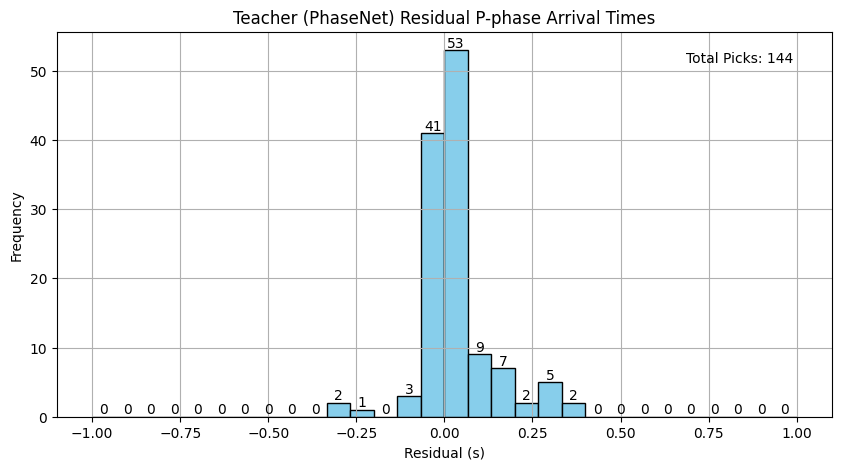

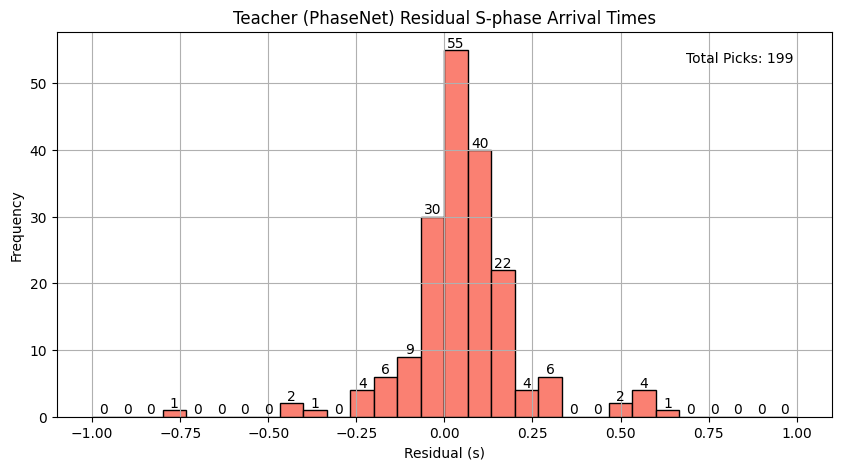


=== Student (XiaoNet) Residual Evaluation ===
Ground truth P peaks: 813, S peaks: 772
P residuals under 0.6s: 224
S residuals under 0.6s: 441
P residuals: mean=-0.0535s, std=3.3517s, total=769
S residuals: mean=-0.3782s, std=4.2337s, total=757
Avg inference time per sample: 1.70 ms ± 0.63 ms


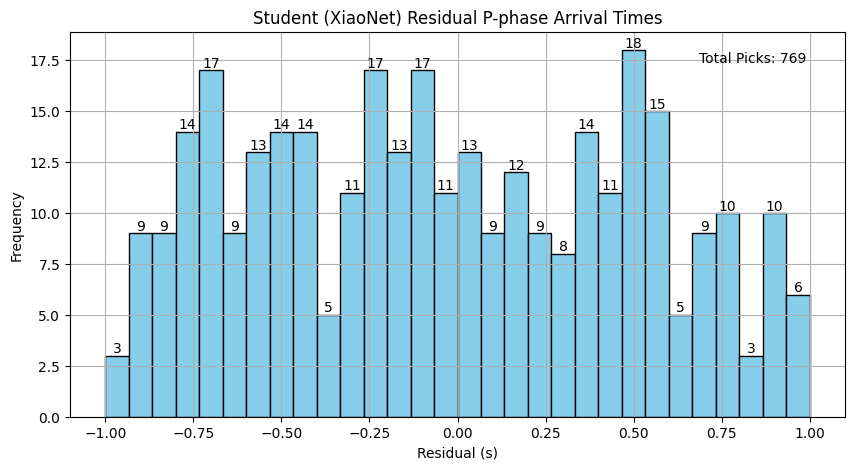

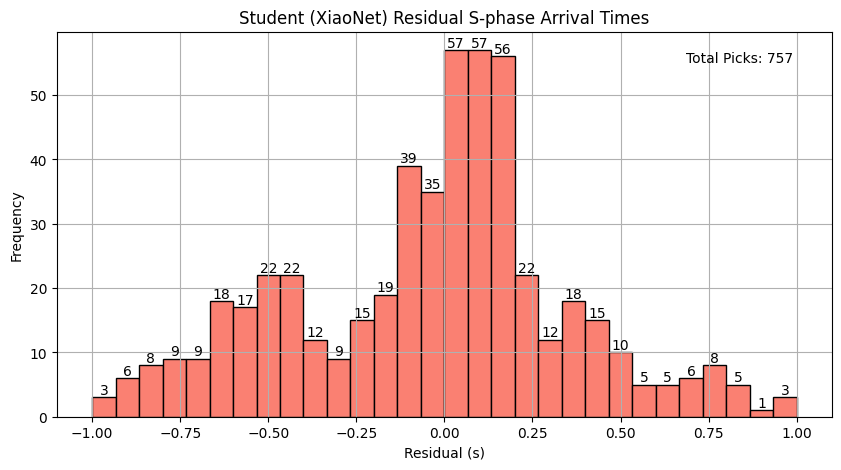


✅ Teacher vs Student Model Comparison
Metric                              | Teacher              | Student             
----------------------------------------------------------------------
Ground truth P peaks                |                  790 |                  813
Ground truth S peaks                |                  771 |                  772
P residuals under 0.6s              |                  125 |                  224
S residuals under 0.6s              |                  185 |                  441
P residuals mean ± std (s)          | 0.6770 ± 2.6368 | -0.0535 ± 3.3517
S residuals mean ± std (s)          | 0.0449 ± 1.5461 | -0.3782 ± 4.2337
Avg inference time per sample (ms)  | 3.31 ± 4.17 | 1.70 ± 0.63
Student vs Teacher Speedup          | -                    | 1.94x faster


In [80]:
# ------------------------------
# Evaluate Teacher Model
# ------------------------------
teacher_results = evaluate_model_residuals_with_time(
    model=teacher_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # or None for full dataset
    model_name="Teacher (PhaseNet)"
)

# ------------------------------
# Evaluate Student Model
# ------------------------------
student_results = evaluate_model_residuals_with_time(
    model=student_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # keep same number of samples for fair comparison
    model_name="Student (XiaoNet)"
)

# ------------------------------
# Compute Speedup
# ------------------------------
speedup = teacher_results['avg_inference_time'] / student_results['avg_inference_time']

# ------------------------------
# Print Full Comparison Table
# ------------------------------
print("\n" + "="*70)
print("✅ Teacher vs Student Model Comparison")
print("="*70)
print(f"{'Metric':35} | {'Teacher':20} | {'Student':20}")
print("-"*70)
print(f"{'Ground truth P peaks':35} | {teacher_results['groundtruth_p_peaks']:20} | {student_results['groundtruth_p_peaks']:20}")
print(f"{'Ground truth S peaks':35} | {teacher_results['groundtruth_s_peaks']:20} | {student_results['groundtruth_s_peaks']:20}")
print(f"{'P residuals under 0.6s':35} | {teacher_results['count_p_under_tol']:20} | {student_results['count_p_under_tol']:20}")
print(f"{'S residuals under 0.6s':35} | {teacher_results['count_s_under_tol']:20} | {student_results['count_s_under_tol']:20}")
print(f"{'P residuals mean ± std (s)':35} | {teacher_results['mean_p']:.4f} ± {teacher_results['std_p']:.4f} | {student_results['mean_p']:.4f} ± {student_results['std_p']:.4f}")
print(f"{'S residuals mean ± std (s)':35} | {teacher_results['mean_s']:.4f} ± {teacher_results['std_s']:.4f} | {student_results['mean_s']:.4f} ± {student_results['std_s']:.4f}")
print(f"{'Avg inference time per sample (ms)':35} | {teacher_results['avg_inference_time']*1000:.2f} ± {teacher_results['std_inference_time']*1000:.2f} | {student_results['avg_inference_time']*1000:.2f} ± {student_results['std_inference_time']*1000:.2f}")
print(f"{'Student vs Teacher Speedup':35} | {'-':20} | {speedup:.2f}x faster")
print("="*70)


In [81]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import numpy as np
from scipy.signal import find_peaks

# Load model function
def load_model(model_class, model_filename, device, **kwargs):
    """
    Load a model from a file.
    Args:
        model_class: Model class (e.g., sbm.PhaseNet or your custom XiaoNet)
        model_filename: Filename of the saved model weights
        device: Device to load the model onto
        **kwargs: Additional arguments for model initialization
    Returns:
        Model with loaded weights
    """
    model = model_class(**kwargs)
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load your student model (adjust the class and parameters as needed)
# If you have a custom student model:
# from your_module import XiaoNet
# student_model = load_model(XiaoNet, "best_student_distilled.pth", device)

# Create output folders
output_folder = "comparison_examples"
os.makedirs(output_folder, exist_ok=True)

# Parameters for peak detection
sampling_rate = 100  # Hz
height = 0.5
distance = 100

print(f"\nGenerating {100} comparison examples...")
print(f"Parameters: height={height}, distance={distance}, sampling_rate={sampling_rate}Hz")

# Generate comparison plots
for i in range(1, 101):
    # Get a sample
    sample = dev_generator[np.random.randint(len(dev_generator))]
    
    # Find ground truth peaks
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
    y_p_times = y_p_peaks / sampling_rate
    y_s_times = y_s_peaks / sampling_rate
    
    # Get teacher predictions
    with torch.no_grad():
        teacher_pred = teacher_model(torch.tensor(sample["X"], device=device).unsqueeze(0))
        teacher_pred = teacher_pred[0].cpu().numpy()
    
    # Get student predictions
    with torch.no_grad():
        student_pred = student_model(torch.tensor(sample["X"], device=device).unsqueeze(0))
        student_pred = student_pred[0].cpu().numpy()
    
    # Find peaks in teacher predictions
    teacher_p_prob = teacher_pred[0]
    teacher_s_prob = teacher_pred[1]
    teacher_p_peaks, _ = find_peaks(teacher_p_prob, height=height, distance=distance)
    teacher_s_peaks, _ = find_peaks(teacher_s_prob, height=height, distance=distance)
    teacher_p_times = teacher_p_peaks / sampling_rate
    teacher_s_times = teacher_s_peaks / sampling_rate
    
    # Find peaks in student predictions
    student_p_prob = student_pred[0]
    student_s_prob = student_pred[1]
    student_p_peaks, _ = find_peaks(student_p_prob, height=height, distance=distance)
    student_s_peaks, _ = find_peaks(student_s_prob, height=height, distance=distance)
    student_p_times = student_p_peaks / sampling_rate
    student_s_times = student_s_peaks / sampling_rate
    
    # Create comparison plot
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.3, height_ratios=[3, 1, 1, 1, 1])
    
    # Row 1: Input waveforms (shared)
    ax_waveform = fig.add_subplot(gs[0, :])
    ax_waveform.plot(sample["X"].T, linewidth=0.8)
    ax_waveform.set_title('Input Seismic Waveforms (3 channels)', fontsize=14, fontweight='bold')
    ax_waveform.set_ylabel('Amplitude')
    ax_waveform.grid(True, alpha=0.3)
    ax_waveform.legend(['Channel 1', 'Channel 2', 'Channel 3'], loc='upper right')
    
    # Row 2: Ground Truth
    ax_gt_left = fig.add_subplot(gs[1, 0])
    ax_gt_right = fig.add_subplot(gs[1, 1])
    
    for ax in [ax_gt_left, ax_gt_right]:
        ax.plot(sample["y"][0], label='P-phase GT', color='red', alpha=0.6)
        ax.plot(sample["y"][1], label='S-phase GT', color='blue', alpha=0.6)
        ax.plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', 
               label=f'P peaks ({len(y_p_peaks)})', color='darkred', markersize=8)
        ax.plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', 
               label=f'S peaks ({len(y_s_peaks)})', color='darkblue', markersize=8)
        ax.set_ylabel('Probability')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    ax_gt_left.set_title('Ground Truth Labels', fontsize=12, fontweight='bold')
    ax_gt_right.set_title('Ground Truth Labels', fontsize=12, fontweight='bold')
    
    # Row 3: Teacher Predictions
    ax_teacher = fig.add_subplot(gs[2, 0])
    ax_teacher.plot(teacher_p_prob, label='P-phase Prob', color='red', alpha=0.6)
    ax_teacher.plot(teacher_p_peaks, teacher_p_prob[teacher_p_peaks], 'x', 
                   label=f'P peaks ({len(teacher_p_peaks)})', color='darkred', markersize=10, markeredgewidth=2)
    ax_teacher.plot(teacher_s_prob, label='S-phase Prob', color='blue', alpha=0.6)
    ax_teacher.plot(teacher_s_peaks, teacher_s_prob[teacher_s_peaks], 'x', 
                   label=f'S peaks ({len(teacher_s_peaks)})', color='darkblue', markersize=10, markeredgewidth=2)
    ax_teacher.set_title('Teacher Model Predictions (PhaseNet)', fontsize=12, fontweight='bold', color='green')
    ax_teacher.set_ylabel('Probability')
    ax_teacher.legend(loc='upper right', fontsize=8)
    ax_teacher.grid(True, alpha=0.3)
    
    # Row 3: Student Predictions
    ax_student = fig.add_subplot(gs[2, 1])
    ax_student.plot(student_p_prob, label='P-phase Prob', color='red', alpha=0.6)
    ax_student.plot(student_p_peaks, student_p_prob[student_p_peaks], 'x', 
                   label=f'P peaks ({len(student_p_peaks)})', color='darkred', markersize=10, markeredgewidth=2)
    ax_student.plot(student_s_prob, label='S-phase Prob', color='blue', alpha=0.6)
    ax_student.plot(student_s_peaks, student_s_prob[student_s_peaks], 'x', 
                   label=f'S peaks ({len(student_s_peaks)})', color='darkblue', markersize=10, markeredgewidth=2)
    ax_student.set_title('Student Model Predictions', fontsize=12, fontweight='bold', color='purple')
    ax_student.set_ylabel('Probability')
    ax_student.legend(loc='upper right', fontsize=8)
    ax_student.grid(True, alpha=0.3)
    
    # Row 4: Probability comparison overlay - Teacher
    ax_overlay_teacher = fig.add_subplot(gs[3, 0])
    ax_overlay_teacher.plot(sample["y"][0], label='GT P-phase', color='red', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_teacher.plot(teacher_p_prob, label='Teacher P-phase', color='red', alpha=0.8)
    ax_overlay_teacher.plot(sample["y"][1], label='GT S-phase', color='blue', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_teacher.plot(teacher_s_prob, label='Teacher S-phase', color='blue', alpha=0.8)
    ax_overlay_teacher.set_title('Teacher vs Ground Truth Overlay', fontsize=11)
    ax_overlay_teacher.set_ylabel('Probability')
    ax_overlay_teacher.legend(loc='upper right', fontsize=7)
    ax_overlay_teacher.grid(True, alpha=0.3)
    
    # Row 4: Probability comparison overlay - Student
    ax_overlay_student = fig.add_subplot(gs[3, 1])
    ax_overlay_student.plot(sample["y"][0], label='GT P-phase', color='red', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_student.plot(student_p_prob, label='Student P-phase', color='red', alpha=0.8)
    ax_overlay_student.plot(sample["y"][1], label='GT S-phase', color='blue', 
                           linestyle='--', alpha=0.5, linewidth=2)
    ax_overlay_student.plot(student_s_prob, label='Student S-phase', color='blue', alpha=0.8)
    ax_overlay_student.set_title('Student vs Ground Truth Overlay', fontsize=11)
    ax_overlay_student.set_ylabel('Probability')
    ax_overlay_student.legend(loc='upper right', fontsize=7)
    ax_overlay_student.grid(True, alpha=0.3)
    
    # Row 5: Direct Teacher vs Student comparison
    ax_compare_p = fig.add_subplot(gs[4, 0])
    ax_compare_p.plot(teacher_p_prob, label='Teacher P-phase', color='green', alpha=0.7, linewidth=2)
    ax_compare_p.plot(student_p_prob, label='Student P-phase', color='purple', 
                     alpha=0.7, linewidth=2, linestyle='--')
    ax_compare_p.plot(sample["y"][0], label='Ground Truth', color='black', 
                     alpha=0.4, linewidth=1, linestyle=':')
    ax_compare_p.set_title('P-phase: Teacher vs Student', fontsize=11)
    ax_compare_p.set_xlabel('Sample Index')
    ax_compare_p.set_ylabel('Probability')
    ax_compare_p.legend(loc='upper right', fontsize=8)
    ax_compare_p.grid(True, alpha=0.3)
    
    ax_compare_s = fig.add_subplot(gs[4, 1])
    ax_compare_s.plot(teacher_s_prob, label='Teacher S-phase', color='green', alpha=0.7, linewidth=2)
    ax_compare_s.plot(student_s_prob, label='Student S-phase', color='purple', 
                     alpha=0.7, linewidth=2, linestyle='--')
    ax_compare_s.plot(sample["y"][1], label='Ground Truth', color='black', 
                     alpha=0.4, linewidth=1, linestyle=':')
    ax_compare_s.set_title('S-phase: Teacher vs Student', fontsize=11)
    ax_compare_s.set_xlabel('Sample Index')
    ax_compare_s.set_ylabel('Probability')
    ax_compare_s.legend(loc='upper right', fontsize=8)
    ax_compare_s.grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle(f'Example {i}: Teacher vs Student Model Comparison', 
                fontsize=16, fontweight='bold', y=0.995)
    
    # Save figure
    plot_filename = os.path.join(output_folder, f"Comparison_{i:03d}.png")
    plt.savefig(plot_filename, dpi=200, bbox_inches='tight')
    plt.close(fig)
    
    # Calculate residuals for both models
    teacher_residuals_p = []
    teacher_residuals_s = []
    student_residuals_p = []
    student_residuals_s = []
    
    for y_p_time in y_p_times:
        if len(teacher_p_times) > 0:
            residuals = teacher_p_times - y_p_time
            teacher_residuals_p.append(residuals[np.argmin(np.abs(residuals))])
        if len(student_p_times) > 0:
            residuals = student_p_times - y_p_time
            student_residuals_p.append(residuals[np.argmin(np.abs(residuals))])
    
    for y_s_time in y_s_times:
        if len(teacher_s_times) > 0:
            residuals = teacher_s_times - y_s_time
            teacher_residuals_s.append(residuals[np.argmin(np.abs(residuals))])
        if len(student_s_times) > 0:
            residuals = student_s_times - y_s_time
            student_residuals_s.append(residuals[np.argmin(np.abs(residuals))])
    
    # Save results to text file
    results_filename = os.path.join(output_folder, f"Comparison_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Example {i} - Comparison Results\n")
        f.write("="*60 + "\n\n")
        
        f.write("GROUND TRUTH:\n")
        f.write(f"  P arrival times: {y_p_times}\n")
        f.write(f"  S arrival times: {y_s_times}\n\n")
        
        f.write("TEACHER MODEL (PhaseNet):\n")
        f.write(f"  Predicted P times: {teacher_p_times}\n")
        f.write(f"  Predicted S times: {teacher_s_times}\n")
        f.write(f"  P residuals: {teacher_residuals_p}\n")
        f.write(f"  S residuals: {teacher_residuals_s}\n\n")
        
        f.write("STUDENT MODEL:\n")
        f.write(f"  Predicted P times: {student_p_times}\n")
        f.write(f"  Predicted S times: {student_s_times}\n")
        f.write(f"  P residuals: {student_residuals_p}\n")
        f.write(f"  S residuals: {student_residuals_s}\n\n")
        
        f.write("PERFORMANCE COMPARISON:\n")
        if teacher_residuals_p and student_residuals_p:
            f.write(f"  Teacher P MAE: {np.mean(np.abs(teacher_residuals_p)):.4f}s\n")
            f.write(f"  Student P MAE: {np.mean(np.abs(student_residuals_p)):.4f}s\n")
        if teacher_residuals_s and student_residuals_s:
            f.write(f"  Teacher S MAE: {np.mean(np.abs(teacher_residuals_s)):.4f}s\n")
            f.write(f"  Student S MAE: {np.mean(np.abs(student_residuals_s)):.4f}s\n")
    
    if (i % 10 == 0):
        print(f"  Generated {i}/100 comparison examples...")

print(f"\n✓ All comparison examples saved to '{output_folder}/'")
print(f"✓ Generated {100} comparison plots")

# Save parameters
params_filename = os.path.join(output_folder, "Comparison_Parameters.txt")
with open(params_filename, "w") as f:
    f.write("COMPARISON PARAMETERS\n")
    f.write("="*60 + "\n")
    f.write(f"Sampling Rate: {sampling_rate} Hz\n")
    f.write(f"Height Parameter: {height}\n")
    f.write(f"Distance Parameter: {distance}\n")

print(f"✓ Parameters saved to '{params_filename}'")


Generating 100 comparison examples...
Parameters: height=0.5, distance=100, sampling_rate=100Hz
  Generated 10/100 comparison examples...
  Generated 20/100 comparison examples...
  Generated 30/100 comparison examples...
  Generated 40/100 comparison examples...
  Generated 50/100 comparison examples...
  Generated 60/100 comparison examples...
  Generated 70/100 comparison examples...
  Generated 80/100 comparison examples...
  Generated 90/100 comparison examples...
  Generated 100/100 comparison examples...

✓ All comparison examples saved to 'comparison_examples/'
✓ Generated 100 comparison plots
✓ Parameters saved to 'comparison_examples/Comparison_Parameters.txt'
